In [1]:
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from scipy.optimize import linear_sum_assignment
import sys
import matplotlib.pyplot as plt
import random as rand
from scipy import linalg

print(torch.cuda.device_count())
print(torch.cuda.is_available())
# print(torch.cuda.current_stream())
# print(torch.cuda.current_device())
print(torch.__version__)

2
True
1.0.1.post2


<span style="color:blue">manually select 10 pairs of points for each image pair</span>

In [2]:
p11 = [[81,123], [594,409], [848,504], [167,212], [983,300], [146,581], [57,482],   [242,494], [213,56], [944,639] ]
p12 = [[126,131],[609,412], [857,508], [200,216], [1017,302],[177,579], [97,480],   [268,494], [251,63], [966,647] ]
p21 = [[95,303], [309,433], [36,176],  [419,192], [623,451], [575,224], [157,176],  [73,536],  [398,75], [229,145] ]
p22 = [[118,302],[318,433], [70,175],  [451,191], [639,450], [605,223], [192,175],  [72,536],  [418,74], [265,144] ]
p31 = [[135,50], [52,253],  [165,164], [170,28],  [289,78],  [253,293], [386,112],  [418,11],  [223,197],[418,211] ]
p32 = [[100,49], [58,253],  [159,162], [135,27],  [255,78],  [236,293], [351,112],  [383,12],  [215,196],[383,211] ]
p41 = [[22,152], [109,149], [87,340],  [438,498], [259,504], [448,679], [355,619],  [479,145], [259,153],[196,358] ]
p42 = [[10,163], [108,139], [83,349],  [515,530], [301,537], [539,756], [468,657],  [521,149], [282,138],[217,363] ]
p51 = [[96,236], [366,36],  [314,554], [105,1087],[531,1118],[978,798], [1180,1028],[1192,482],[818,129],[1118,240]]
p52 = [[170,239],[441,41],  [388,557], [172,1089],[601,1118],[1052,800],[1254,1030],[1266,485],[893,133],[1193,244]]

In [3]:
# p11 = \
# [
#     [507,90], [519,428], [519,439],
#     [595,193], [602,597], [602,545],
#     [610,518], [595,409], [400,409],
#     [400,400],
# ]
# p12 = \
# [
#     [517,92], [529,430], [529,442], 
#     [612,195], [613,600], [613,548],
#     [624,520], [609,412], [415,412],
#     [415,403] 
# ]
# p21 = \
# [
#     [605,440], [88,243], [20,184],
#     [125,163], [125,154], [153,163], 
#     [153,162], [226,218], [630,187], 
#     [603, 206]  
# ]
# p22 = \
# [
#     [621, 440], [112, 242], [54, 183],
#     [160, 161], [160, 154], [188, 153],
#     [188, 161], [255, 216], [661, 186],
#     [635, 205]
# ]
# p31 =\
# [
#     [204, 156], [225, 196], [184, 196],
#     [205, 200], [386, 113], [391, 216], 
#     [421, 198], [413, 199], [405, 199], 
#     [405, 192], 
# ]
# p32 =\
# [
#     [200, 154], [216, 195], [184, 196],
#     [199, 199], [353, 115], [356, 215],
#     [385, 198], [377, 198], [371, 198],
#     [370, 192],
# ]
# p41 = \
# [
#     [276, 156], [279, 216], [282, 281],
#     [283, 319], [285, 351], [286, 392],
#     [288, 427], [290, 471], [292, 508],
#     [294, 555],
# ]
# p42 = \
# [
#     [302, 141], [309, 205], [316, 276],
#     [320, 317], [324, 356], [328, 401],
#     [333, 444], [337, 496], [343, 543],
#     [347, 600],
# ]
# p51 = \
# [
#     [106, 1087], [108, 1001], [150, 1087],
#     [957., 504.], [60, 1282], [890, 1260],
#     [1049, 1245], [1118, 240], [1192, 482],
#     [978, 798],
# ]
# p52 = \
# [
#     [173, 1089], [177, 1003], [218, 1089],
#     [1015., 506.], [60, 1282], [942, 1259],
#     [120, 1283], [1186, 242], [1260, 486],
#     [1046, 800],
# ]

<span style="color:blue">initialization</span>

In [4]:
choose = 5   # select between 5 pairs of images (1~5)

if choose == 1:
    path_p = 'Stereo_images/image11.png'
    path_q = 'Stereo_images/image12.png'
    p = p11
    q = p12
    save = '1_'
elif choose == 2:
    path_p = 'Stereo_images/image21.png'
    path_q = 'Stereo_images/image22.png'    
    p = p21
    q = p22
    save = '2_'
elif choose == 3:
    path_p = 'Stereo_images/image31.png'
    path_q = 'Stereo_images/image32.png'    
    p = p31
    q = p32
    save = '3_'
elif choose == 4:
    path_p = 'Stereo_images/image41.png'
    path_q = 'Stereo_images/image42.png'    
    p = p41
    q = p42
    save = '4_'
elif choose == 5:
    path_p = 'Stereo_images/image51.png'
    path_q = 'Stereo_images/image52.png'    
    p = p51
    q = p52
    save = '5_'

<span style="color:blue">plot the selected 10 points pairs</span>

In [5]:
# def plotManual(li, path, num, color):
#     x_list = []
#     y_list = []
#     for x in li:
#         x_list.append(x[0])
#         y_list.append(x[1])
#     im = plt.imread(path)
#     print("dimesnsion of image {}: {}".format(num, im.shape))
#     implot = plt.imshow(im)
#     plt.plot(x_list, y_list, color)
#     plt.show() 
    
# # plot image 1
# plotManual(p, path_p, 1, 'b.')
# # plot image 2
# plotManual(q, path_q, 2, 'r.')

<span style="color:blue">check selected points</span>

In [6]:
# idx = 0    # 0 ~ 9
# img1 = plt.imread(path_p)
# img2 = plt.imread(path_q)

# def getPatch(kps, img, size, choose):
#     cx, cy = kps
#     if choose == 4:
#         img[cy, cx] = 0
#     else:
#         img[cy, cx] = [255, 0, 0]
#     if type(img) is np.ndarray:
#         img = torch.from_numpy(img)
#     h, w = img.shape[:2]      
#     # note: for image, the x direction is the verticle, y-direction is the horizontal...
    
#     cx, cy = kps
#     cx, cy = int(cx), int(cy)
#     dd = int(size/2)
#     xmin, xmax = max(0, cx - dd), min(w, cx + dd ) - 1
#     ymin, ymax = max(0, cy - dd), min(h, cy + dd ) - 1 

#     xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)-1
#     ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)-1
   
#     return img[ymin: ymax, xmin: xmax]

# p1 = p[idx]
# patchImg1 = getPatch(p1, img1, 50, choose)
# plt.imshow(patchImg1)
# plt.show()

# p2 = q[idx]
# patchImg2 = getPatch(p2, img2, 50, choose)
# plt.imshow(patchImg2)
# plt.show()

<span style="color:blue">100 points from description matching</span>

p_keypoints:  torch.Size([5, 100, 2])
q_keypoints:  torch.Size([5, 100, 2])


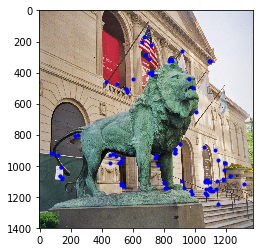

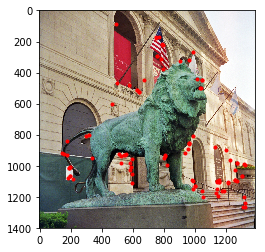

In [9]:
p_point = torch.load("p_keypoints.pt")
q_point = torch.load("q_keypoints.pt")
print("p_keypoints: ", p_point.shape)
print("q_keypoints: ", q_point.shape)

def plotDesc(point, path, color):
    x_list = []
    y_list = []
    for i in range(len(point[choose-1])):
        x_list.append(point[choose-1][i][0])
        y_list.append(point[choose-1][i][1])

    im = plt.imread(path)
    implot = plt.imshow(im)
    plt.plot(x_list, y_list, color)
    plt.show()    

# plot image 1 
plotDesc(p_point, path_p, 'b.') 
# plot image 2
plotDesc(q_point, path_q, 'r.') 

<span style="color:blue">matching points 100-100</span>

In [10]:
p_des = torch.load("p_description.pt")  # torch.Size([5, 100, 128])
q_des = torch.load("q_description.pt")  # torch.Size([5, 100, 128])
p_point = np.array(p_point)
q_point = np.array(q_point)

data = np.zeros((100, 100))
pair_matrix = data.tolist()
cost_matrix = torch.tensor(data)

for i in range(len(p_des[choose-1])):       # 100
    for j in range(len(q_des[choose-1])):   # 100
        pair_matrix[i][j] = (p_point[choose-1][i].tolist(), q_point[choose-1][j].tolist())
        cost_matrix[i][j] = torch.dist(p_des[choose-1][i], q_des[choose-1][j], p=2)

cost_matrix_np = cost_matrix.detach().numpy()
row_ind, col_ind = linear_sum_assignment(cost_matrix_np)   # Hungarian

# C: one-to-one matching pairs
c = []
for i in range(len(col_ind)):
    c.append(pair_matrix[i][col_ind[i]])
    c[i][0].append(1)
    c[i][1].append(1)
# print("\nC:\n", c)    
print("shape of C:", np.shape(c))    # (100, 2, 3)

shape of C: (100, 2, 3)


In [ ]:
def plotFromC(c, idx, path, color):
    x_list = []
    y_list = []
    for i in range(len(c)):
        x_list.append(c[i][idx][0])
        y_list.append(c[i][idx][1])
    im = plt.imread(path)
    implot = plt.imshow(im)
    plt.plot(x_list, y_list, color)
    plt.show()

# plot image 1 
plotFromC(c, 0, path_p, 'b.')
# plot image 2 
plotFromC(c, 1, path_q, 'r.')

<span style="color:blue">estimate F(0) based on C(0)</span>

In [ ]:
def compFundamental(x1, x2, n):
    W = np.zeros((n,9))
    for i in range(n):
        W[i][0] = x1[i][0]*x2[i][0]
        W[i][1] = x1[i][1]*x2[i][0]
        W[i][2] = x2[i][0]
        W[i][3] = x1[i][0]*x2[i][1]
        W[i][4] = x1[i][1]*x2[i][1]
        W[i][5] = x2[i][1]
        W[i][6] = x1[i][0]
        W[i][7] = x1[i][1]
        W[i][8] = 1

    # linear least square solution
    U, S, V = linalg.svd(W)
    F = V[-1].reshape(3, 3)
    # constraint F
    # make rank 2 by zeroing out last singular value
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S),V))
    
    return F

In [ ]:
# compute C0
li_p = []
li_q = []
c0 = []
for i in range(len(p)):
    li_p.append((p[i]))
    li_q.append((q[i]))
    c0.append(([p[i][0], p[i][1], 1], [q[i][0], q[i][1], 1]))
print("C0:\n", c0)

# # estimate F0: method 1
# x1 = []
# x2 = []
# for i in range(len(c0)):
#     x1.append(c0[i][0])
#     x2.append(c0[i][1])
# F0 = compFundamental(x1, x2, 10)
# print("\nF0:\n", F0)

# estimate F0: method 2
pts1 = np.int32(li_p)
pts2 = np.int32(li_q)
F0, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
print("\nF0:\n", F0)

<span style="color:blue">filter out 30 pairs in C</span>

In [ ]:
# C1: one-to-one matching pairs (30, 2, 3)
c1 = []
abs_pFp = []
for i, item in enumerate(c):
    abs_pFp.append([i, abs(np.matmul(np.matmul(c[i][1], F0), np.transpose(c[i][0])))])
sort_list = sorted(abs_pFp, key = lambda x: x[1])
for i in range(30):
    c1.append(c[sort_list[i][0]])

print("C1: ", np.shape(c1))

<span style="color:blue">extend to 40 pairs with C0 & C1, re-estimate F->F(1)</span>

In [ ]:
# C2: (40, 2, 3)
c2 = c1 + c0
print("C2: ", np.shape(c2))

# estimate F1: method 1
x1 = []
x2 = []
for i in range(len(c2)):
    x1.append(c2[i][0])
    x2.append(c2[i][1])
F1 = compFundamental(x1, x2, np.shape(c2)[0])
print("\nF1:\n", F1)

# estimate F1: method 2
# li_p = []
# li_q = []
# for i in range(len(c)):
#     li_p.append((c[i][0][0], c[i][0][1]))
#     li_q.append((c[i][1][0], c[i][1][1]))
# pts1 = np.int32(li_p)
# pts2 = np.int32(li_q)
# F1, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
# print("\nF1:\n", F1)

<span style="color:blue">save points to txt</span>

In [9]:
txtName1 = 'f1_5_1.txt'
txtName2 = 'f1_5_2.txt'
c_matrix = c2

f = open(txtName1, "w")
for i, item in enumerate(c_matrix):
    f.write('{:>20}  {:>20}\n'.format(str(item[0][0]), str(item[0][1])))
f.close()

f = open(txtName2, "w")
for i, item in enumerate(c_matrix):
    f.write('{:>20}  {:>20}\n'.format(str(item[1][0]), str(item[1][1])))
f.close()

NameError: name 'c2' is not defined

<span style="color:blue">find epipoles for F(0) & F(1)</span>

In [10]:
def minEigenvalue(value):
    minimum = float("inf")
    idx = None
    for i, item in enumerate(value):
        if item < minimum:
            idx = i
            minimum = item
    return idx

# eigenvector associated with smallest eigenvalue of F
# e1 is the eigenvector of F
e1_value, e1_vector = np.linalg.eig(F0)
print("eigenvalue for F0: \n", e1_value)
print("eigenvector for F0: \n", e1_vector)
epipole1 = e1_vector[minEigenvalue(e1_value)]
epipole1 /= epipole1[2]
print("epipole for F0: \n", epipole1)

# e2 is the eigenvector of FT
e2_value, e2_vector = np.linalg.eig(np.transpose(F1))
print("\neigenvalue for F1: \n", e2_value)
print("eigenvector for F1: \n", e2_vector)
epipole2 = e2_vector[minEigenvalue(e2_value)]
epipole2 /= epipole2[2]
print("epipole for F1: \n", epipole2)

NameError: name 'F0' is not defined

<span style="color:blue">plot for F(0) & F(1)</span>

In [ ]:
# # method 2

# point_idx1 = 0
# point_idx2 = 7

# # select point in image 1
# point1 = c0[point_idx1][0]
# map_point1 = c0[point_idx1][1]
# print("selected point in image 1: {}\nmapped point in image 2: {}".format(point1, map_point1))
# # select point in image 2
# point2 = c0[point_idx2][1]
# map_point2 = c0[point_idx2][0]
# print("selected point in image 2: {}\nmapped point in image 2: {}".format(point2, map_point2))

# point1 = np.array([[81, 123]])
# l_F0_1 = cv2.computeCorrespondEpilines(point1, 1, F0)
# l_F0_1 /= l_F0_1[0][0][2]
# print(l_F0_1)

# point2 = np.array([[268, 494]])
# l_F0_2 = cv2.computeCorrespondEpilines(point2, 2, F0)
# l_F0_2 /= l_F0_2[0][0][2]
# print(l_F0_2)

selected point in image 1: [81, 123, 1]
mapped point in image 2: [126, 131, 1]
selected point in image 2: [268, 494, 1]
mapped point in image 2: [242, 494, 1]

Epipolar line for F0 1->2:  [ 0.00274174 -0.01026581  1.        ]
Epipolar line for F0 2->1:  [ 1.37681577e-04 -2.09313348e-03  1.00000000e+00]
Epipolar line for F1 1->2:  [-0.02933246  0.02037503  1.        ]
Epipolar line for F1 2->1:  [ 0.00238715 -0.00320395  1.        ]


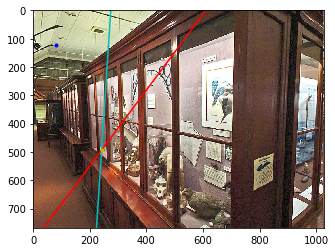

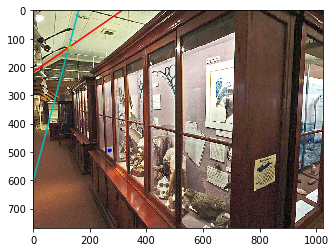

In [129]:
point_idx1 = 0
point_idx2 = 7

# select point in image 1
point1 = c0[point_idx1][0]
map_point1 = c0[point_idx1][1]
print("selected point in image 1: {}\nmapped point in image 2: {}".format(point1, map_point1))
# select point in image 2
point2 = c0[point_idx2][1]
map_point2 = c0[point_idx2][0]
print("selected point in image 2: {}\nmapped point in image 2: {}".format(point2, map_point2))

def compEpipolarLine(point, F, reverse):
    x = np.array(point)
    if reverse:
        l = np.matmul(np.transpose(F), x)
    else:
        l = np.matmul(F, x)
    l /= l[2]
    return l

# epipolar line for F0
l_F0_1 = compEpipolarLine(point1, F0, False)
print("\nEpipolar line for F0 1->2: ", l_F0_1)
l_F0_2 = compEpipolarLine(point2, F0, True)
print("Epipolar line for F0 2->1: ", l_F0_2)
# epipolar line for F1
l_F1_1 = compEpipolarLine(point1, F1, False)
print("Epipolar line for F1 1->2: ", l_F1_1)
l_F1_2 = compEpipolarLine(point2, F1, True)
print("Epipolar line for F1 2->1: ", l_F1_2)

def plotEpiLine(p_ori, p_map, path, l_1, l_2):
    im = plt.imread(path)
    implot = plt.imshow(im)
    plt.xlim(0, im.shape[1])
    plt.ylim(0, im.shape[0])
    plt.gca().invert_yaxis()
    plt.plot([p_map[0]-10000000*l_1[0], p_map[0]+10000000*l_1[0]], [p_map[1]-10000000*l_1[1], p_map[1]+10000000*l_1[1]], 'c')
    plt.plot([p_map[0]-10000000*l_2[0], p_map[0]+10000000*l_2[0]], [p_map[1]-10000000*l_2[1], p_map[1]+10000000*l_2[1]], 'r')
    plt.plot(p_map[0], p_map[1], 'y.')
    plt.plot(p_ori[0], p_ori[1], 'b.')
    plt.show()
    return implot

# plot in image1
fig = plotEpiLine(point1, map_point2, path_p, l_F0_2, l_F1_2)
fig.figure.savefig(save + 'image1.png')
# plot in image2
fig = plotEpiLine(point2, map_point1, path_q, l_F0_1, l_F1_1)
fig.figure.savefig(save + 'image2.png')

<span style="color:blue">(plot all epipolar line)</span>

(10, 2, 3)


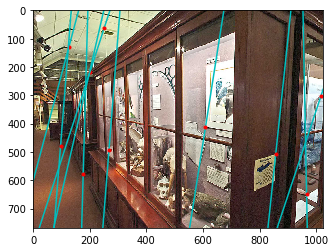

(10, 2, 3)


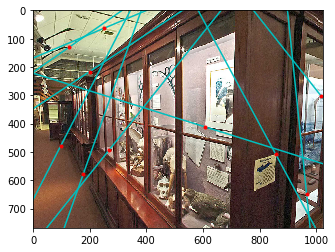

In [130]:
# F0 =[[-0.0000,   -0.0000,    0.0028],
#     [0.0000,   -0.0000,   -0.0019],
#    [-0.0026,    0.0021,   -0.1453]]

choose_c = c0    #c0, c2
choose_F = F0    #F0, F1

def printAllLine(c, F):
    print(np.shape(c))
#     for i in range(len(c)):    
#         point = c[i][0]
#         im = plt.imread(path_p)
#         implot = plt.imshow(im)
#         plt.plot(point[0], point[1],'b.')
#     plt.show()

    for i in range(len(c)):    
        point1 = c[i][0]
        point2 = c[i][1] 
        x = np.array(point1)
        l = np.matmul(F, x)
        l /= l[2]
#         print(l)
        im = plt.imread(path_q)
        implot = plt.imshow(im)
        plt.xlim(0, im.shape[1])
        plt.ylim(0, im.shape[0])
        plt.gca().invert_yaxis()
        plt.plot([point2[0]-10000000*l[0], point2[0]+10000000*l[0]], [point2[1]-10000000*l[1], point2[1]+10000000*l[1]], 'c')
        plt.plot(point2[0], point2[1],'r.')
    plt.show()
    
printAllLine(choose_c, choose_F)
printAllLine(c0, F1)